In [4]:
# Pip might complain about the Pandas version. The notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbench2.git

  Cloning https://github.com/google-research/weatherbench2.git to /tmp/pip-req-build-8qejyk37
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbench2.git /tmp/pip-req-build-8qejyk37
  Resolved https://github.com/google-research/weatherbench2.git to commit b0dc18dee8ba2c106a80e6a020d052e19f2d2c1b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import apache_beam   # Needs to be imported separately to avoid TypingError
import weatherbench2
import xarray as xr

In [ ]:
# !gcloud auth application-default login


/bin/bash: line 1: gcloud: command not found


In [7]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'

In [8]:
xr.open_zarr(forecast_path)

/tmp/ipykernel_3457812/2213774576.py:1: FutureWarning: In a future version, xarray will not decode the variable 'prediction_timedelta' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  xr.open_zarr(forecast_path)


<xarray.Dataset> Size: 172GB
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * time                      (time) datetime64[ns] 41kB 2016-01-01 ... 2022-...
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 328B 00:...
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [9]:
from weatherbench2 import config

In [10]:
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

data_config = config.Data(selection=selection, paths=paths)

In [11]:
climatology = xr.open_zarr(climatology_path)

In [12]:
from weatherbench2.metrics import MSE, ACC

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
  )
}

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
      regions=regions
  )
}

In [13]:
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 25 minutes

/data2/xiaoqinfeng/miniconda3/lib/python3.13/site-packages/weatherbench2/evaluation.py:117: FutureWarning: In a future version, xarray will not decode the variable 'prediction_timedelta' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  forecast = xr.open_zarr(
/data2/xiaoqinfeng/miniconda3/lib/python3.13/site-packages/weatherbench2/evaluation.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths,

In [14]:
# 适合大数据
# evaluation.evaluate_with_beam(
#     data_config,
#     eval_configs,
#     runner='DirectRunner',
#     input_chunks={'time': 20},
# )

In [15]:
results = xr.open_dataset('./deterministic.nc')
results

<xarray.Dataset> Size: 8kB
Dimensions:         (metric: 2, region: 3, lead_time: 41, level: 3)
Coordinates:
  * metric          (metric) <U3 24B 'acc' 'mse'
  * region          (region) <U13 156B 'global' 'tropics' 'extra-tropics'
  * lead_time       (lead_time) timedelta64[ns] 328B 0 days 00:00:00 ... 10 d...
  * level           (level) int32 12B 500 700 850
Data variables:
    2m_temperature  (metric, region, lead_time) float64 2kB ...
    geopotential    (metric, region, lead_time, level) float64 6kB ...

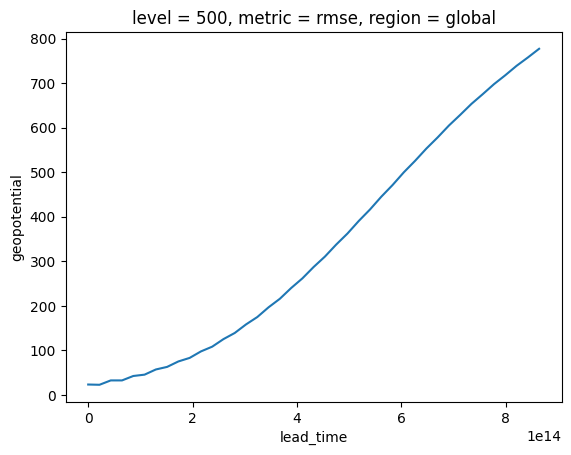

In [16]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)
results['geopotential'].sel(metric='rmse', level=500, region='global').plot();